# Text generation with LSTM: 

This notebook is from Lazy Programmer's 'poetry.py' from Advanced NLP course (nlp3).

In this notebook, Robert Frost's poem 'The Road Not Taken' was used to train a single LSTM model to generate text. 
The architecture of the model consists of only 4 layers: an input layer, an embedding layer, a LSTM layer and a Dense layer for prediction. 

In [1]:
from __future__ import print_function, division
from builtins import range, input
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam, SGD

In [3]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [4]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 200
LATENT_DIM = 25

In [6]:
# load in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

all_lines = input_texts + target_texts

In [11]:
target_texts[:10]

['Two roads diverged in a yellow wood, <eos>',
 'And sorry I could not travel both <eos>',
 'And be one traveler, long I stood <eos>',
 'And looked down one as far as I could <eos>',
 'To where it bent in the undergrowth; <eos>',
 'Then took the other, as just as fair, <eos>',
 'And having perhaps the better claim <eos>',
 'Because it was grassy and wanted wear, <eos>',
 'Though as for that the passing there <eos>',
 'Had worn them really about the same, <eos>']

# Tokenizing

In [8]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, filters='')

In [9]:
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [10]:
target_sequences[:10]

[[104, 537, 538, 9, 7, 539, 540, 2],
 [5, 541, 6, 65, 31, 934, 141, 2],
 [5, 27, 24, 935, 152, 6, 221, 2],
 [5, 167, 67, 24, 17, 128, 17, 6, 65, 2],
 [4, 40, 11, 936, 9, 3, 937, 2],
 [91, 189, 3, 542, 17, 77, 17, 938, 2],
 [5, 142, 265, 3, 222, 939, 2],
 [319, 11, 14, 543, 5, 223, 940, 2],
 [122, 17, 15, 13, 3, 544, 55, 2],
 [23, 545, 52, 404, 111, 3, 546, 2]]

In [12]:
#find max seq length
max_seq_len = max(len(s) for s in input_sequences)
print('Max sequence is:', max_seq_len)

Max sequence is: 12


In [13]:
word2idx = tokenizer.word_index
print('Found %s unique tokens' %len(word2idx))

Found 3056 unique tokens


In [15]:
list(word2idx.items())[:10]

[('<sos>', 1),
 ('<eos>', 2),
 ('the', 3),
 ('to', 4),
 ('and', 5),
 ('i', 6),
 ('a', 7),
 ('of', 8),
 ('in', 9),
 ('you', 10)]

In [16]:
word2idx.get('town')

148

In [17]:
#PADDING
max_seq_length = min(max_seq_len, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen = max_seq_length, padding = 'post')
target_sequences = pad_sequences(target_sequences, maxlen = max_seq_length, padding = 'post')

# Pretrained Glove to use in the Embedding layer

The embedding layer is created using the following steps:

- First, the pretrain Glove for word embedding is loaded. This is just a mapping of word to a fixed length (of size embedding dimension) vector. 

- Next, an embedding matrix of size (num_words (or max_vocab_size), embedding_dim) is created. The embedding matrix only contains word vectors for those words found in the word2idx, which was created by calling tokenizer.word2idx. 

In [18]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [19]:
len(word2vec.get('roads')), word2vec.get('roads')

(50,
 array([ 0.66258 ,  0.2123  ,  0.77968 , -0.29735 , -1.7562  , -0.25392 ,
        -0.9175  , -0.12077 ,  0.082226, -1.4477  , -0.87622 , -0.61384 ,
        -0.18897 , -0.92008 , -0.76244 ,  0.412   ,  0.50552 ,  0.23814 ,
         0.69856 , -0.66039 ,  0.25735 , -0.21809 , -0.34929 ,  0.39163 ,
         0.56563 , -0.14954 ,  0.5056  ,  0.79658 ,  1.5936  , -0.1479  ,
         3.2168  ,  0.17621 ,  0.38781 , -0.23386 ,  0.27452 ,  0.94828 ,
         0.27032 , -0.003935, -0.49437 ,  1.4444  , -0.78306 , -0.14778 ,
         0.89745 , -0.20894 , -0.56203 ,  0.015886, -0.71619 , -0.99149 ,
         0.79767 , -0.9672  ], dtype=float32))

In [20]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print('There are %s words' %num_words)

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...
There are 3000 words


In [22]:
embedding_matrix.shape

(3000, 50)

# Neural network model with Embedding layer

In [23]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  trainable=False
)

In [24]:
# create an LSTM network with a single LSTM

#LSTM layer
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)

#There are 3 inputs:
#1. input state
input_ = Input(shape=(max_seq_length,))
#2. hidden state of LSTM
initial_h = Input(shape=(LATENT_DIM,))
#3. cell state of LSTM
initial_c = Input(shape=(LATENT_DIM,))
#Embedding layer
x = embedding_layer(input_)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
#Dense layer
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 50)       150000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                              

In [26]:
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(learning_rate=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

In [27]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_seq_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [28]:
#use zeros for initial states h and c
z = np.zeros((len(input_sequences), LATENT_DIM))

r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/200
9/9 [==============================] - 4s 212ms/step - loss: 5.3906 - accuracy: 0.0224 - val_loss: 5.0641 - val_accuracy: 0.0229
Epoch 2/200
9/9 [==============================] - 1s 132ms/step - loss: 4.6467 - accuracy: 0.0424 - val_loss: 4.8003 - val_accuracy: 0.0833
Epoch 3/200
9/9 [==============================] - 1s 127ms/step - loss: 4.4640 - accuracy: 0.0833 - val_loss: 4.8647 - val_accuracy: 0.0833
Epoch 4/200
9/9 [==============================] - 1s 131ms/step - loss: 4.4378 - accuracy: 0.0833 - val_loss: 4.8948 - val_accuracy: 0.0833
Epoch 5/200
9/9 [==============================] - 1s 142ms/step - loss: 4.4325 - accuracy: 0.0876 - val_loss: 4.8800 - val_accuracy: 0.0871
Epoch 6/200
9/9 [==============================] - 1s 129ms/step - loss: 4.4033 - accuracy: 0.0866 - val_loss: 4.8349 - val_accuracy: 0.0833
Epoch 7/200
9/9 [==============================] - 1s 126ms/step - loss: 4.3800 - accuracy: 0.0885 - val_loss: 4.8140 - val_accuracy: 0.0871
Epoch 8/200
9

Epoch 59/200
9/9 [==============================] - 1s 131ms/step - loss: 3.6351 - accuracy: 0.1161 - val_loss: 4.7735 - val_accuracy: 0.0969
Epoch 60/200
9/9 [==============================] - 1s 133ms/step - loss: 3.6244 - accuracy: 0.1161 - val_loss: 4.7681 - val_accuracy: 0.0978
Epoch 61/200
9/9 [==============================] - 1s 133ms/step - loss: 3.6167 - accuracy: 0.1172 - val_loss: 4.7754 - val_accuracy: 0.0990
Epoch 62/200
9/9 [==============================] - 1s 135ms/step - loss: 3.6074 - accuracy: 0.1165 - val_loss: 4.7716 - val_accuracy: 0.0981
Epoch 63/200
9/9 [==============================] - 1s 133ms/step - loss: 3.5981 - accuracy: 0.1167 - val_loss: 4.7802 - val_accuracy: 0.0987
Epoch 64/200
9/9 [==============================] - 1s 133ms/step - loss: 3.5889 - accuracy: 0.1172 - val_loss: 4.7847 - val_accuracy: 0.0998
Epoch 65/200
9/9 [==============================] - 1s 133ms/step - loss: 3.5819 - accuracy: 0.1176 - val_loss: 4.7747 - val_accuracy: 0.0992
Epoch 

9/9 [==============================] - 1s 143ms/step - loss: 3.2349 - accuracy: 0.1292 - val_loss: 4.9702 - val_accuracy: 0.0940
Epoch 117/200
9/9 [==============================] - 2s 191ms/step - loss: 3.2282 - accuracy: 0.1302 - val_loss: 4.9780 - val_accuracy: 0.0943
Epoch 118/200
9/9 [==============================] - 1s 138ms/step - loss: 3.2232 - accuracy: 0.1302 - val_loss: 4.9804 - val_accuracy: 0.0935
Epoch 119/200
9/9 [==============================] - 1s 139ms/step - loss: 3.2174 - accuracy: 0.1295 - val_loss: 4.9801 - val_accuracy: 0.0935
Epoch 120/200
9/9 [==============================] - 1s 136ms/step - loss: 3.2119 - accuracy: 0.1307 - val_loss: 4.9852 - val_accuracy: 0.0943
Epoch 121/200
9/9 [==============================] - 1s 146ms/step - loss: 3.2099 - accuracy: 0.1302 - val_loss: 5.0021 - val_accuracy: 0.0938
Epoch 122/200
9/9 [==============================] - 1s 151ms/step - loss: 3.2030 - accuracy: 0.1316 - val_loss: 4.9954 - val_accuracy: 0.0935
Epoch 123/200

9/9 [==============================] - 1s 149ms/step - loss: 3.0140 - accuracy: 0.1453 - val_loss: 5.2318 - val_accuracy: 0.0920
Epoch 174/200
9/9 [==============================] - 1s 147ms/step - loss: 3.0100 - accuracy: 0.1453 - val_loss: 5.2410 - val_accuracy: 0.0911
Epoch 175/200
9/9 [==============================] - 1s 141ms/step - loss: 3.0059 - accuracy: 0.1466 - val_loss: 5.2389 - val_accuracy: 0.0920
Epoch 176/200
9/9 [==============================] - 1s 138ms/step - loss: 3.0066 - accuracy: 0.1450 - val_loss: 5.2532 - val_accuracy: 0.0920
Epoch 177/200
9/9 [==============================] - 1s 154ms/step - loss: 3.0058 - accuracy: 0.1470 - val_loss: 5.2510 - val_accuracy: 0.0923
Epoch 178/200
9/9 [==============================] - 1s 152ms/step - loss: 3.0013 - accuracy: 0.1466 - val_loss: 5.2684 - val_accuracy: 0.0923
Epoch 179/200
9/9 [==============================] - 1s 145ms/step - loss: 2.9989 - accuracy: 0.1473 - val_loss: 5.2527 - val_accuracy: 0.0920
Epoch 180/200

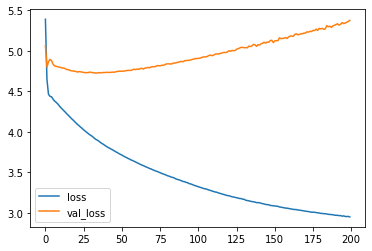

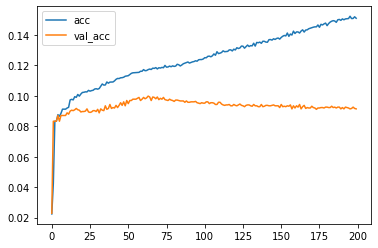

In [29]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Make a sampling model

Instead of using the model above that takes as input an entire sequence, we need to create a sampling model to process one word at a time. 

In [30]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [31]:
sampling_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             150000      ['input_4[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                            

In [32]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [33]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_seq_length):
    o, h, c = sampling_model.predict([np_input, h, c], verbose = 0)
    #o is the list of probabilities for the next word
    #this is where we take a sample from
    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [34]:
# generate a 4 line poem
while True:
  for _ in range(8):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break


that's 'better who keep track. might donkey's
word as what what me so are people i it.' should, her
someone's rain?' -
of time as where and the stove. from the raspberry girl, because
and think the slumbering aftermath, goblet piece arch everywhere!— weakly
you saw to ever out the tangle
so just to a worse too tell the some mistake. leaf, home
she swept his doubts for muffled. where 'well back pieces four books
---generate another? [Y/n]---y
where driven it listened they fade,
all claiming there mad.' times i partial song), 'you summer
i had now i serve i seize people wheels
to me to give of treading windows. though.
like, that i had them, my head time to talk, he whined.
so to piano in seven then. to felt and both find burnt-
of there no way we'd
and threw at his longer of cedar.
---generate another? [Y/n]---n
